In [1]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"


In [2]:
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


In [3]:
def sliding_window(data,timestep,n_step):
  xs=list()
  ys=list()
  for i in range(0,len(data)-timestep,n_step):
    x=data[i:i+timestep]
    y=data[i:i+timestep]
    xs.append(x)
    ys.append(y)
  return np.array(xs)[...,np.newaxis],np.array(ys)[...,np.newaxis]


In [4]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])


In [5]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

In [6]:
import pandas as pd 

In [7]:
df1=pd.read_csv('/content/drive/My Drive/datasets/time_series_covid_19_confirmed.csv')
df1

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170,174,237,273,281,299,349,367,423,444,484,521,555,607,665
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223,243,259,277,304,333,361,377,383,400,409,416,433,446,467
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370,376,390,428,439,466,501,525,545,564,583,601,601,638,646
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7,7,8,8,8,10,14,16,17,19,19,19,19,19,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Saint Pierre and Miquelon,France,46.885200,-56.315900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1
260,NaN,South Sudan,6.877000,31.307000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,2,3,4,4,4,4
261,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,6,6
262,NaN,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,4


In [ ]:
data_sequence=df1.iloc[:,4:]
data_sequence

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,...,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,...,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170,174,237,273,281,299,349,367,423,444,484,521,555,607,665
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223,243,259,277,304,333,361,377,383,400,409,416,433,446,467
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,...,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370,376,390,428,439,466,501,525,545,564,583,601,601,638,646
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7,7,8,8,8,10,14,16,17,19,19,19,19,19,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1
260,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,2,3,4,4,4,4
261,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,6,6
262,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,4


In [ ]:
data_sequence=np.sum(data_sequence)

data_sequence.shape

(83,)

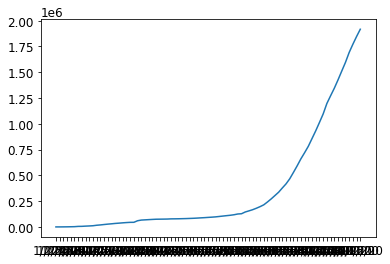

In [ ]:
plt.plot(data_sequence)

In [ ]:
x1,y1=sliding_window(data_sequence,timestep=1,n_step=1)
y1.shape

(82, 1, 1)

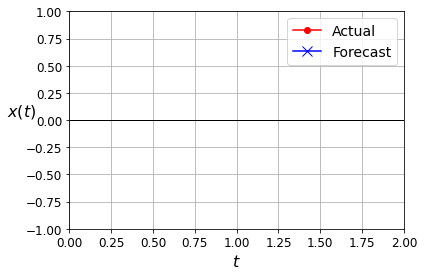

In [ ]:
n_steps=1
plot_multiple_forecasts(x1,y1,Y_pred=y1)

In [ ]:
X_train=x1[:70]
Y_train=y1[:70]
X_test=x1[70:]
Y_test=y1[70:]

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)
model1 = keras.models.Sequential([
    keras.layers.GRU(40, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(40,return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10)),
])
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 40)          5160      
_________________________________________________________________
gru_1 (GRU)                  (None, None, 40)          9840      
_________________________________________________________________
time_distributed (TimeDistri (None, None, 10)          410       
Total params: 15,410
Trainable params: 15,410
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model1.compile(loss="mse", optimizer="sgd", metrics=[last_time_step_mse])


In [ ]:

history = model1.fit(X_train,Y_train, epochs=100,validation_split=0.1)

Epoch 1/100
2/2 [==============================] - 1s 382ms/step - loss: 17322233856.0000 - last_time_step_mse: 17354321920.0000 - val_loss: 444547530752.0000 - val_last_time_step_mse: 444547530752.0000
Epoch 2/100
2/2 [==============================] - 0s 21ms/step - loss: 16327311360.0000 - last_time_step_mse: 16260126720.0000 - val_loss: 435274547200.0000 - val_last_time_step_mse: 435274547200.0000
Epoch 3/100
2/2 [==============================] - 0s 20ms/step - loss: 15182875648.0000 - last_time_step_mse: 15075051520.0000 - val_loss: 426786521088.0000 - val_last_time_step_mse: 426786521088.0000
Epoch 4/100
2/2 [==============================] - 0s 21ms/step - loss: 14094651392.0000 - last_time_step_mse: 14052481024.0000 - val_loss: 419069231104.0000 - val_last_time_step_mse: 419069231104.0000
Epoch 5/100
2/2 [==============================] - 0s 20ms/step - loss: 13187689472.0000 - last_time_step_mse: 13194115072.0000 - val_loss: 412077850624.0000 - val_last_time_step_mse: 4120778

In [ ]:
predtest=model1.predict(X_test)
predtest

array([[[95109.8  , 95109.805, 95109.805, 95109.805, 95109.8  ,
         95109.8  , 95109.805, 95109.8  , 95109.805, 95109.8  ]],

       [[95109.8  , 95109.805, 95109.805, 95109.805, 95109.8  ,
         95109.8  , 95109.805, 95109.8  , 95109.805, 95109.8  ]],

       [[95109.8  , 95109.805, 95109.805, 95109.805, 95109.8  ,
         95109.8  , 95109.805, 95109.8  , 95109.805, 95109.8  ]],

       [[95109.8  , 95109.805, 95109.805, 95109.805, 95109.8  ,
         95109.8  , 95109.805, 95109.8  , 95109.805, 95109.8  ]],

       [[95109.8  , 95109.805, 95109.805, 95109.805, 95109.8  ,
         95109.8  , 95109.805, 95109.8  , 95109.805, 95109.8  ]],

       [[95109.8  , 95109.805, 95109.805, 95109.805, 95109.8  ,
         95109.8  , 95109.805, 95109.8  , 95109.805, 95109.8  ]],

       [[95109.8  , 95109.805, 95109.805, 95109.805, 95109.8  ,
         95109.8  , 95109.805, 95109.8  , 95109.805, 95109.8  ]],

       [[95109.8  , 95109.805, 95109.805, 95109.805, 95109.8  ,
         95109.8  ,

In [ ]:
predtest=predtest.reshape(predtest.shape[0]*predtest.shape[1]*1)

ValueError: ignored

ValueError: ignored

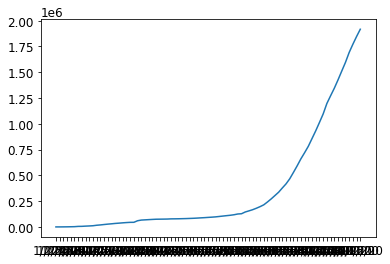

In [ ]:
plt.plot(data_sequence)
plt.plot(predtest,'.--')
plt.xlabel('date')
plt.ylim(10000,200000)
plt.ylabel('Corona Infection')

**Iran's Infectons**

In [ ]:
df1_iran=df1.loc[df1['Country/Region']=='Iran']
df1_iran

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20
133,NaN,Iran,32.0,53.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,5,18,28,43,61,95,139,...,3513,4747,5823,6566,7161,8042,9000,10075,11364,12729,13938,14991,16169,17361,18407,19644,20610,21638,23049,24811,27017,29406,32332,35408,38309,41495,44605,47593,50468,53183,55743,58226,60500,62589,64586,66220,68192,70029,71686,73303


In [ ]:
data_sequence1=df1_iran.iloc[:,4:]
data_sequence1=np.sum(data_sequence1)
data_sequence1

1/22/20        0
1/23/20        0
1/24/20        0
1/25/20        0
1/26/20        0
           ...  
4/9/20     66220
4/10/20    68192
4/11/20    70029
4/12/20    71686
4/13/20    73303
Length: 83, dtype: int64

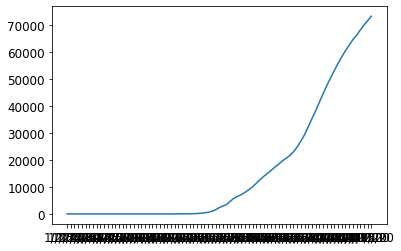

In [ ]:
plt.plot(data_sequence1)

In [ ]:
x2,y2=sliding_window(data_sequence1,timestep=1,n_step=1)


In [ ]:
y2

array([[[    0]],

       [[    0]],

       [[    0]],

       [[    0]],

       [[    0]],

       [[    0]],

       [[    0]],

       [[    0]],

       [[    0]],

       [[    0]],

       [[    0]],

       [[    0]],

       [[    0]],

       [[    0]],

       [[    0]],

       [[    0]],

       [[    0]],

       [[    0]],

       [[    0]],

       [[    0]],

       [[    0]],

       [[    0]],

       [[    0]],

       [[    0]],

       [[    0]],

       [[    0]],

       [[    0]],

       [[    0]],

       [[    2]],

       [[    5]],

       [[   18]],

       [[   28]],

       [[   43]],

       [[   61]],

       [[   95]],

       [[  139]],

       [[  245]],

       [[  388]],

       [[  593]],

       [[  978]],

       [[ 1501]],

       [[ 2336]],

       [[ 2922]],

       [[ 3513]],

       [[ 4747]],

       [[ 5823]],

       [[ 6566]],

       [[ 7161]],

       [[ 8042]],

       [[ 9000]],

       [[10075]],

       [[11364]],

       [[127

In [ ]:
y2.shape

(82, 1, 1)

In [ ]:
x3_train=x2[:70]
y3_train=y2[:70]
x3_test=x2[70:]
y3_test=y2[70:]

In [ ]:
model2 = keras.models.Sequential([
    keras.layers.Conv1D(20,kernel_size=3,strides=1,padding="same",input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(10,return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1,activation='linear')),
])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 20)          80        
_________________________________________________________________
gru_2 (GRU)                  (None, None, 20)          2520      
_________________________________________________________________
gru_3 (GRU)                  (None, None, 10)          960       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 1)           11        
Total params: 3,571
Trainable params: 3,571
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2.compile(loss="mse", optimizer="sgd", metrics=[last_time_step_mse])
history = model2.fit(x3_train,y3_train, epochs=100,validation_split=0.1)

Epoch 1/100
2/2 [==============================] - 1s 369ms/step - loss: 70191152.0000 - last_time_step_mse: 70277360.0000 - val_loss: 1263548672.0000 - val_last_time_step_mse: 1263548672.0000
Epoch 2/100
2/2 [==============================] - 0s 22ms/step - loss: 65157784.0000 - last_time_step_mse: 64854832.0000 - val_loss: 1190688768.0000 - val_last_time_step_mse: 1190688768.0000
Epoch 3/100
2/2 [==============================] - 0s 21ms/step - loss: 57255800.0000 - last_time_step_mse: 56846284.0000 - val_loss: 1112442240.0000 - val_last_time_step_mse: 1112442240.0000
Epoch 4/100
2/2 [==============================] - 0s 20ms/step - loss: 49645152.0000 - last_time_step_mse: 49514412.0000 - val_loss: 1045463232.0000 - val_last_time_step_mse: 1045463232.0000
Epoch 5/100
2/2 [==============================] - 0s 21ms/step - loss: 44666808.0000 - last_time_step_mse: 44725068.0000 - val_loss: 995804864.0000 - val_last_time_step_mse: 995804864.0000
Epoch 6/100
2/2 [========================

In [ ]:
predtest1=model2.predict(x3_test)
predtest1

array([[[8177.414]],

       [[8177.414]],

       [[8177.414]],

       [[8177.414]],

       [[8177.414]],

       [[8177.414]],

       [[8177.414]],

       [[8177.414]],

       [[8177.414]],

       [[8177.414]],

       [[8177.414]],

       [[8177.414]]], dtype=float32)

In [ ]:
np.sum(x3_train[:70])


527564

NameError: ignored

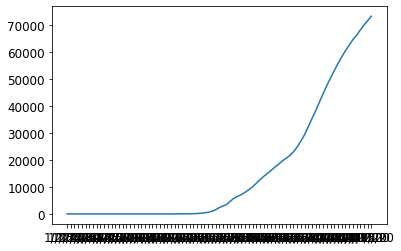

In [ ]:
plt.plot(data_sequence1)
plt.plot(predtest1_reshape,".--")
plt.xlabel('date')

plt.ylabel('Corona Infection of Iran')

Text(0, 0.5, 'Corona Infection of Iran')

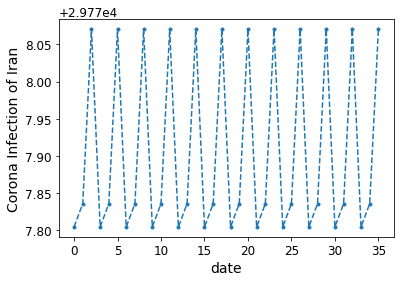

In [ ]:

plt.plot(predtest1_reshape,".--")
plt.xlabel('date')
plt.ylabel('Corona Infection of Iran')

In [ ]:
np.sum(predtest1)+

88213.984

In [ ]:
88213.984+527564

615777.9839999999

In [ ]:
model2.save('Irancorona.h5')

In [ ]:
df1_Italy=df1.loc[df1['Country/Region']=='Italy']



In [ ]:
data_sequence2=df1_Italy.iloc[:,4:]
data_sequence2=np.sum(data_sequence2)


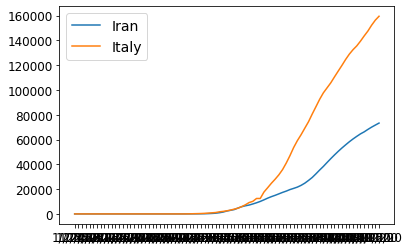

In [ ]:
plt.plot(data_sequence1,label='Iran')
plt.plot(data_sequence2,label='Italy')
plt.legend(fontsize=14)